In [1]:
%%capture
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

if IN_COLAB:
    print("Running in colab, downloading packages")
    !pip install -q condacolab;
    import condacolab
    condacolab.install()
    !conda install numpy scipy jupyter matplotlib mpmath setuptools setuptools_scm mock nose -y
    !conda install -c conda-forge brian2 -y
    !pip install neurodynex3
else:
    print("Not running in Google Colab")


In [2]:
#Importing libraries
import brian2 as b2
import matplotlib.pyplot as plt
import numpy as np
from neurodynex3.leaky_integrate_and_fire import LIF
from neurodynex3.tools import input_factory, plot_tools
from scipy.integrate import odeint
from scipy.stats import linregress 


## Global functions and constants

In [3]:
#Numerical neurons parameters for the project
V_REST = 15 * b2.mV
V_RESET = -50 * b2.mV
MEMBRANE_RESISTANCE = 50 * b2.ohm
MEMBRANE_TIME_SCALE = 10 * b2.ms
FIRING_THRESHOLD = 0 * b2.mV
BETA = 100000 * b2.Hz
np.random.seed(0) 
folder="plots/"

In [4]:
def Iext(t, I0 = 0.5 * b2.mamp, w = 100*b2.Hz, dt=b2.ms):
    return I0*(1+np.sin(w*t*dt))

def escape_function(voltage, beta=BETA, firing_threshold=FIRING_THRESHOLD) :
  return (voltage > firing_threshold)*beta

def raster_plot(ST, ax, dt=1e-2*b2.ms):
    num_time_steps, num_neurons = ST.shape

    # Create an empty figure
    # Iterate over the neurons
    for neuron_idx in range(num_neurons):
        # Get the indices where the neuron fired (value is True)
        firing_indices = np.where(ST[:,neuron_idx])[0]
        
        # Plot the firing indices against the neuron index
        ax.scatter(firing_indices*dt, np.full_like(firing_indices, neuron_idx),
                  color='black', marker='.', linewidth=1)

    # Set plot limits and labels
    ax.set_xlim([0, num_time_steps]*dt)
    ax.set_ylim([0, num_neurons])
    ax.set_xlabel('Time [s]')
    ax.set_ylabel('Neuron')

    # Show the plot
def IV_plot(Ie, Vs, t, ax,dt = 1e-2*b2.ms):
    if not(Ie is None):
      ax2 = ax.twinx()

      # Shift the position of the right axis upwards

      # Plot the second curve on the second axis
      ax2.plot(t*dt, Ie, label='$I_{ext}(t)$', c="orange")
      ax2.set_ylabel('Current [A]', color='orange')
      ax2.tick_params('y', colors='orange')
      ax2.set_ylim([np.min(Vs[:, 0])-10*b2.mV, np.max(Ie)+10*b2.mV])

    ax.set_ylim([np.min(Vs[:, 0])-10*b2.mV, np.max(Ie)+10*b2.mV])
    ax.plot(t*dt, Vs[:, 0], label='$V_1(t)$')
    ax.set_xlabel(f'Time [s]')
    ax.set_ylabel('Voltage(V)')
    ax.grid()
    ax.legend()
    ax2.legend(loc='lower right')
    
def activity_plot(ST, t, ax, tA=1*b2.ms,dt = 1e-2*b2.ms,N=100):
    At = np.array([np.mean(s) for s in ST])/dt
    At = np.convolve(At, np.ones_like(np.linspace(-tA/2, tA/2, int(tA/dt)))/ tA*dt, mode='same')

    ax.plot(t*dt, At, label='A(t)')
    ax.set_xlabel(f'Time [s]')
    ax.set_ylabel('Activity(Hz)')
    ax.grid()
    ax.legend()


In [5]:
              
def non_interacting(Vi, I, T=100*b2.ms,dt=b2.ms):
    steps = int(T/dt)+1 
    spike_train = np.zeros((steps, len(Vi))).astype(bool)
    voltages = np.zeros((steps, len(Vi)))*b2.mV

    voltages[0] = Vi
    # Set the initial condition and time points
    for i in range(0,steps-1):
        voltages[i+1] = voltages[i]+dt/MEMBRANE_TIME_SCALE*((-voltages[i]+V_REST)+MEMBRANE_RESISTANCE*I[i])
        firing = escape_function(voltages[i])*dt
        voltages[i+1]+=(V_RESET-voltages[i+1])*firing
        spike_train[i]=firing

    return voltages, spike_train

## Exercice 0

In [6]:
N = 100
dt = 1e-2*b2.ms
T=100*b2.ms
steps = int(T/dt)+1 
t = np.arange(0, steps, 1)
I = Iext(t, dt=dt)
Vi = np.random.uniform(V_RESET,FIRING_THRESHOLD,N)*1e3*b2.mV

In [7]:
Vs0, ST0 = non_interacting(Vi, I=I, dt=dt, T=T)

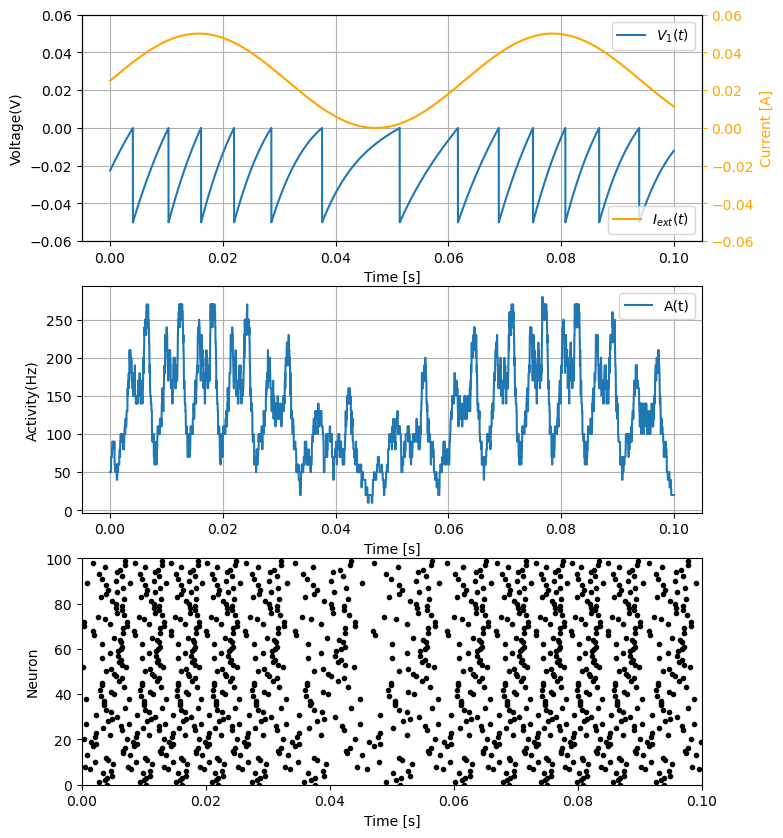

In [8]:
steps = Vs0.shape[0]
Ie0 = Iext(t, dt=dt)*MEMBRANE_RESISTANCE
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 10))
IV_plot(Ie0, Vs0,t, ax1)
activity_plot(ST0,t,ax2)
raster_plot(ST0, ax3)
plt.savefig(folder+'ex0.svg')

In this case simulation we are using a periodically changing current which in term induces a periodically alternating voltage in the neurons. As we can see on the raster plot, the behavior does not significantly change between the end and the beginning of the simulation. We can in fact deduce that the alternating current will not lead to a synchrony of spike firing or a convergence to a specific behavior. As the neurons do not interact with each other, the change in their voltage in only determined by the alternating current and the shape of the activity will depend on the initial voltages Vi.

# Exercice 1
## Question 1

In [9]:
tepsilon = 2*b2.ms
J = 20*b2.mV
delta = 5*b2.ms
                
def synchronous_state(vi, I, T=600*b2.ms,dt=b2.ms, beta=BETA, eA=0, eB=0):
    steps = int(T/dt)+1    
    spike_train = np.zeros((steps, len(vi))).astype(bool)
    voltages = np.zeros((steps, len(vi)))*b2.mV
    voltages[0] = vi
    epsilonA = np.full(steps,eA)*b2.Hz
    epsilonB = np.full(steps, eB)*b2.Hz
    for i in range(0,steps-1):
      voltages[i+1]= voltages[i]+dt*(-(voltages[i]-V_REST-MEMBRANE_RESISTANCE*I[i])+MEMBRANE_TIME_SCALE*J*epsilonA[i-int(delta/dt)]) / MEMBRANE_TIME_SCALE
      firing = np.random.binomial(1,escape_function(voltages[i], beta=beta)*dt)
      voltages[i+1]+=(V_RESET-voltages[i+1])*firing
      spike_train[i]=firing
      if i*dt > delta:
        epsilonB[i+1] = (-dt*(epsilonB[i])+np.mean(spike_train[i])) /tepsilon +epsilonB[i]
        epsilonA[i+1] = dt*(-epsilonA[i]+epsilonB[i]) / tepsilon +epsilonA[i]
    return voltages, spike_train, epsilonA, epsilonB

## Question 2

In [10]:
T=600*b2.ms
Vs1, ST1, epsilonA, epsilonB = synchronous_state(Vi, dt=dt, T=T, I=np.zeros(int(T/dt))*1e3*b2.mA)

In [11]:
i30=np.round(30*b2.ms/dt).astype(int)
i200=np.round(200*b2.ms/dt).astype(int)

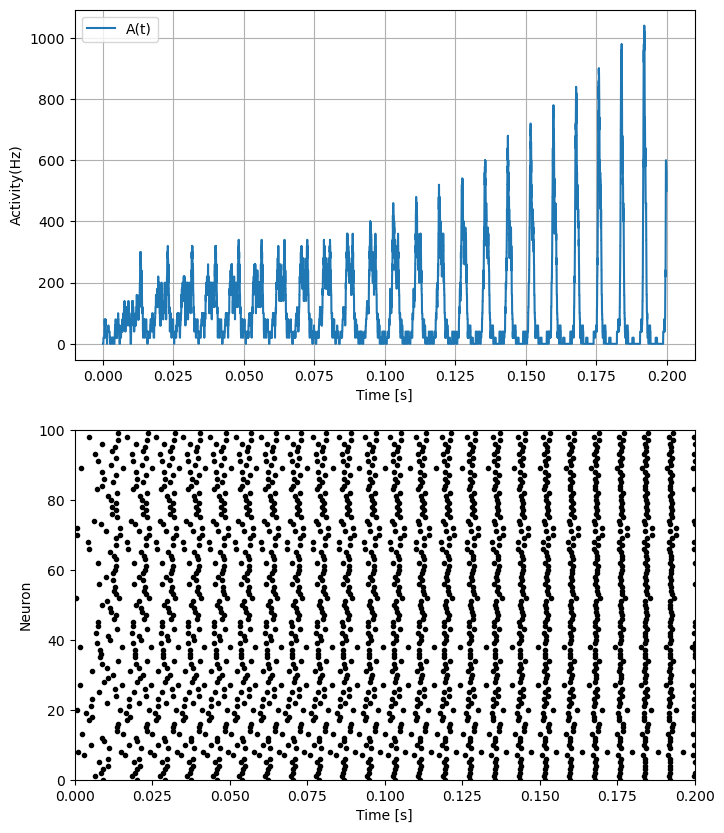

In [12]:
steps = Vs1.shape[0]
t = np.arange(0, steps, 1)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10))
activity_plot(ST1[0:i200,:],t[0:i200],ax1, tA=0.5*b2.ms)
raster_plot(ST1[0:i200,:], ax2)
plt.savefig(folder+'ex1_2_first.svg')

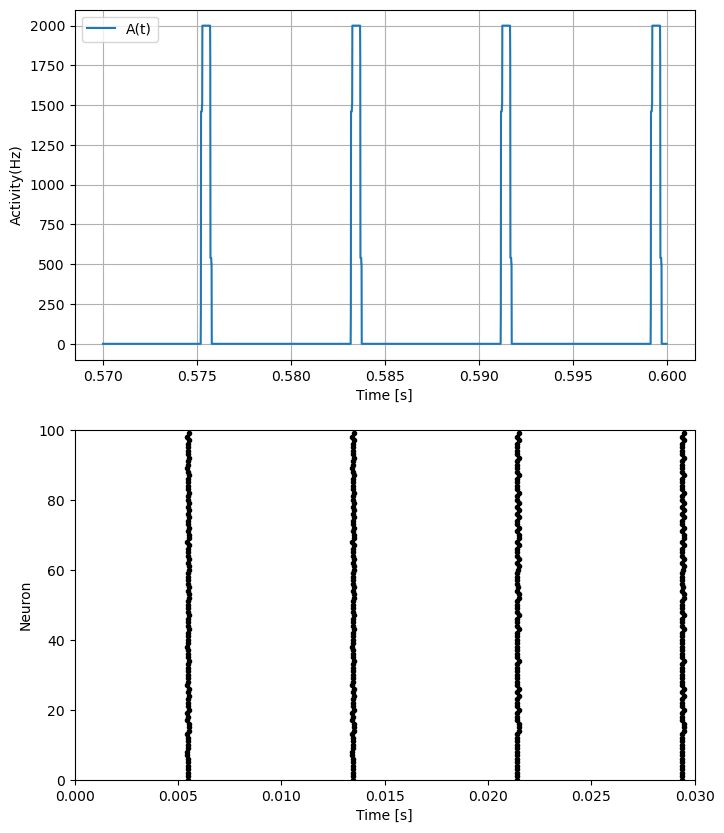

In [13]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10))
activity_plot(ST1[-1-i30:-1],t[-1-i30:-1],ax1, tA=0.5*b2.ms)
raster_plot(ST1[-1-i30:-1], ax2)
plt.savefig(folder+'ex1_2_last.svg')

In [14]:
period = np.mean([np.diff(np.nonzero(s)) for s in ST1[-1-i30:-1].T])*dt
print(f"The period is {period*1e3} ms")

The period is 7.980000000000001 ms


As we can on the first 200 ms, the activity starts in a non synchronous state with small peaks and high noise. Each peak correspond to the moment in time (rather an intervals as we are using a rect filter)where several neurons fired together. As the simulations evolves, the peaks increase in size and the noise is reduced which can be explained by simultaneous firing of the neurons

As $t \rightarrow +\infty$, the synchronicity increases wich results in nearly simulataneous firing as shown by vertically and periodically aligned columns in the raster plots and rectangle pulse of $2e3 Hz$ activity plots. We can assume that for $t$ very large and due to the very small noise in the system, all neurons will fire simultaneously which would correspond to perfectly aligned columns in the raster plot.

## Question 3

In [15]:
dt = 1e-2*b2.ms
T=600*b2.ms
I0=-0.25*b2.mA
Vs2, ST2, _, _ = synchronous_state(Vi, dt=dt, T=T, I=np.full(int(T/dt), I0)*1e3*b2.mA)

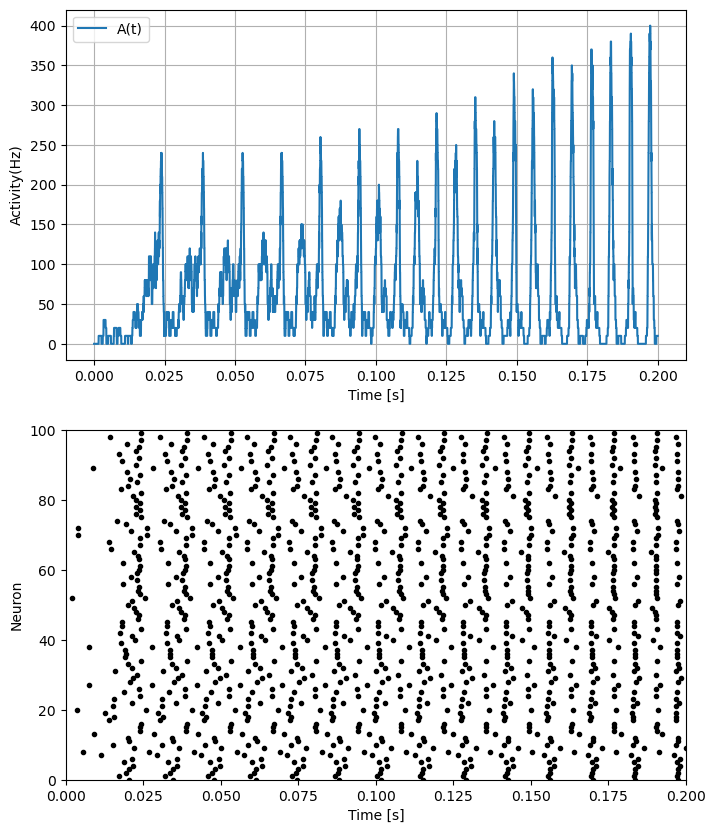

In [16]:
steps = Vs1.shape[0]
t = np.arange(0, steps, 1)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10))
activity_plot(ST2[0:i200,:],t[0:i200],ax1)
raster_plot(ST2[0:i200,:], ax2)
plt.savefig(folder+'ex1_3_first.svg')

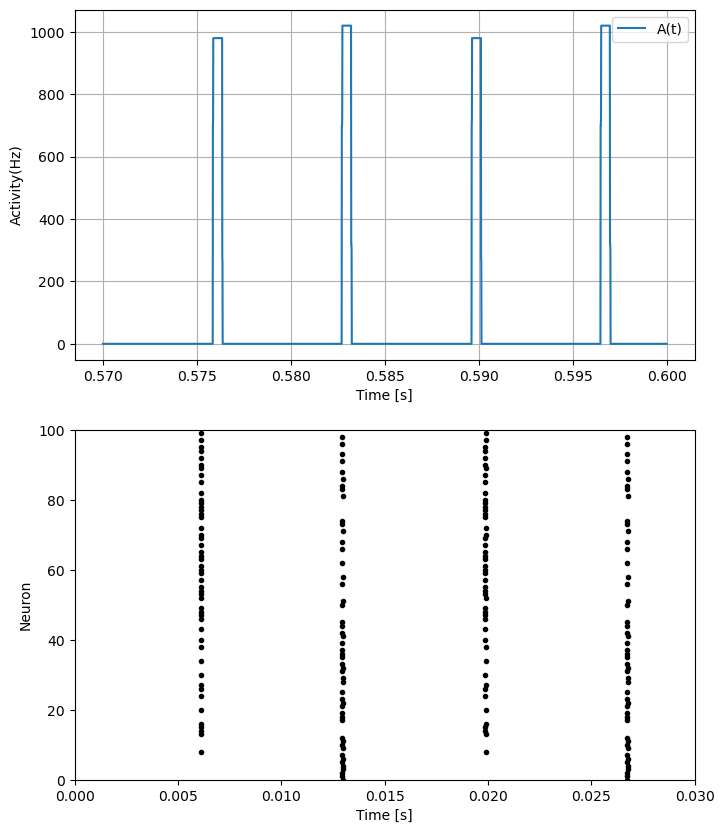

In [17]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10))
activity_plot(ST2[-1-i30:-1],t[-1-i30:-1],ax1, tA=0.5*b2.ms)
raster_plot(ST2[-1-i30:-1], ax2)
plt.savefig(folder+'ex1_3_last.svg')

In [18]:
print(f"New Vrest : {-MEMBRANE_RESISTANCE*I0+V_REST} V")

New Vrest : 0.0275 V


In [19]:
period = np.mean([np.diff(np.nonzero(s)) for s in ST2[-1-i30:-1].T])*dt
print(f"The period is {period*1e3} ms")

The period is 13.770000000000001 ms


By decreasing the constant external current the synchrony is still preserved at large $t$ but the amplitude of the rectangle pulses on the activity plot is decreased by half, meaning less neurons fire at the same time. We can also observe periodical fluctuations in the amplitude of the activity peaks, oscillating below and above $1e3 Hz$. This could mean that there is more than one group of neurons firing at the same time, at least two one with period $T$ and the other with period $T/2.$

If $V_{rest} = 27.5 mV$ then the dynamics would be the same as if there was no external current

# Exercice 2

## Question 1

In [20]:
def intervals_spike(ST, tn1=None):
  if tn1 is None:
    tn1 = np.nonzero(ST[:,0])[0]
    start =0
  else:
    start =1
    # Iterating through the firing times of neuron 1
  start = 1
  rtimes = []
  intervals = []
  Imins = []

  for i in range(len(tn1)-1):
    Imax = tn1[i+1]
    Imin = tn1[i]
    intervals.append(Imax-Imin)
    t = []
    # Iterating through the neurons
    for n in range(start, ST.shape[1]):
      indices = np.nonzero(ST[:,n])[0]
      indices = indices[(indices>Imin)*(indices<=Imax)]
      if len(indices)>0:
        t.append((indices[0]-Imin)*dt)
      else:
        t.append(None)
    rtimes.append(t)
    Imins.append(Imin)


  return np.array(rtimes), intervals*dt, Imins*dt



In [21]:
def plot_intervals(rtimes, intervals, Imins,ax=None):
  if ax is None:
    fig, ax = plt.subplots()

  for n in range(rtimes.shape[1]):
    indices = [i for i, val in enumerate(rtimes[:,n]) if val is not None]
    ax.scatter(intervals[indices]+Imins[indices], rtimes[:,n][indices], s=1, c="grey")

  ax.scatter(intervals+Imins, intervals, marker="x", s=20, c="black", label = "Intervals")
  ax.set_title("Intervals ($\hat{t}^{f+1}-\hat{t}^{f}$) and relative firing times $\Delta t_{1,n}^f(\hat{t}_{1}^f)$  vs time")
  ax.set_xlabel("Time [s]")
  ax.set_ylabel("Firing Times [s]")
  ax.legend()
  

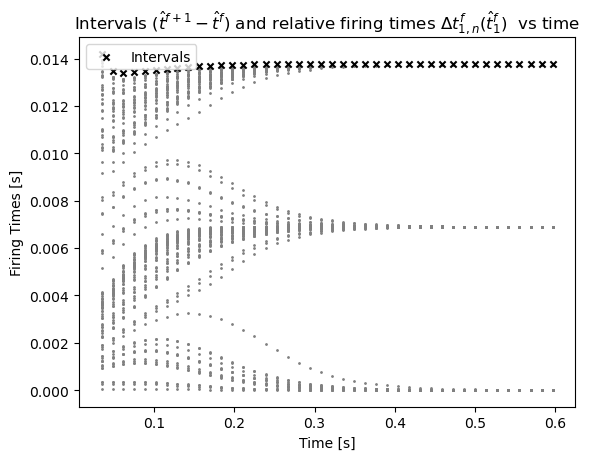

In [22]:
rtimes, intervals, Imins = intervals_spike(ST2)
plot_intervals(rtimes, intervals, Imins)
plt.savefig(folder+'ex2_1.svg')

We can see that after synchronisation of the network, there are three clusters of neurons. Ones which fire very closely to neuron 1, other that fire after ~7 ms and finally ones that fire after 14 ms. The first and last group of neurons is basically one same cluster as shifting a periodic signal by its period gives you the same signal, i.e. eventhough that the corresponding firing times are shifted $T$ it results in neurons firing at the same time. Interestingly, the second group of neurons has a period of $T/2$ as observed on 2 peak amplitudes of the activity plot of Q 2.

## Question 2

In [23]:
T=1e3*b2.ms
I0 = -0.25*b2.mA
steps = np.arange(0,int(T/dt)+1, 1)*dt
I = I0*(steps>500*b2.ms)
Vs3, ST3,_,_ = synchronous_state(Vi, dt=dt, T=T, I=I)

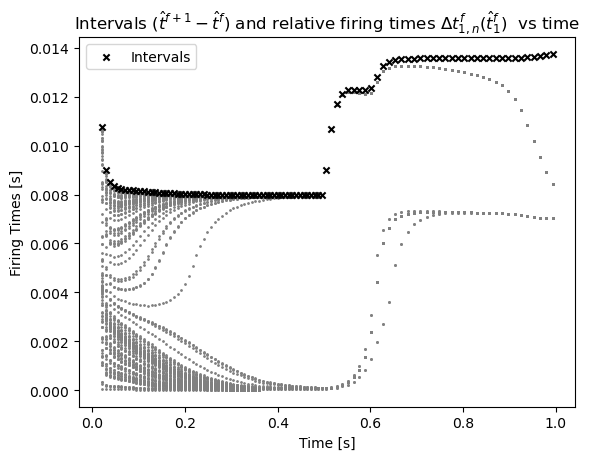

In [24]:
rtimes, intervals, Imins = intervals_spike(ST3)
plot_intervals(rtimes, intervals, Imins)
plt.savefig(folder+'ex2_2.svg')

If we perform a phase-plane analysis or a similar tool to analyze the period of the network, introducing a step current induces a shift in the corresponding null-clines which results in a change of both the fixed points and their stability. Here we introduce a negative current at $t = T_{step}$ which results in a change in the number of fixed points $2 \rightarrow 3$ as well as their values.

## Question 3

In [25]:
BETA2 = 25e3*b2.Hz

In [26]:
T=2e3*b2.ms
I0 = -0.25*b2.mA
steps = np.arange(0,int(T/dt)+1, 1)*dt
I = I0*steps/T 
Vi4=np.full(len(Vs1[-1]), np.median(Vs1[-1][0]))*1e3*b2.mV

In [27]:
Vs4, ST4,_,_ = synchronous_state(Vi4, dt=dt, T=T, I=I, beta=BETA2, eA=epsilonA[-1-int(delta/dt)], eB=epsilonB[-1-int(delta/dt)])

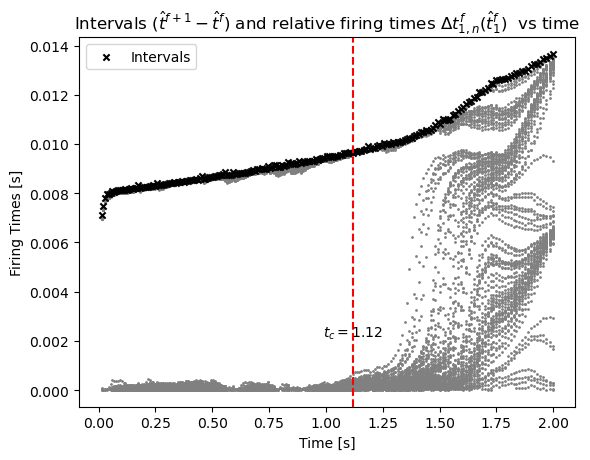

In [28]:
rtimes, intervals, Imins = intervals_spike(ST4)
plot_intervals(rtimes, intervals, Imins)
plt.axvline(x=1.12, color='r', linestyle='--')
plt.text(1.12, 0.002, f'$t_c={1.12}$', ha='center', va='bottom')
plt.savefig(folder+'ex2_3_first.svg')

In [29]:
Ic=I0*1.12*1e3*b2.ms/T 
print(f"The current which induces a change in stability is{Ic} A and the corresponding resting voltage is {V_REST-Ic*MEMBRANE_RESISTANCE} V")


The current which induces a change in stability is-0.00014000000000000001 A and the corresponding resting voltage is 0.022 V


## Exercice 3

## Dilation factor
## Question 1

In [40]:
T=600*b2.ms
Vi5=np.full(len(Vs1[-1]), np.median(Vs1[-1][0]))*1e3*b2.mV
i5 = np.random.choice(range(100))
Vi5[i5]=Vi5[i5]+10*b2.mV
Vs5,ST5,_, _ = synchronous_state(Vi5, dt=dt, T=T, I=np.zeros(int(T/dt))*1e3*b2.mA,eA=epsilonA[-1-int(delta/dt)], eB=epsilonB[-1-int(delta/dt)])


In [47]:
delays5 = np.abs(np.nonzero(ST5[:, i5])[0]-np.nonzero(ST5[:,i5-1])[0])[0:10]*dt

In [48]:
def plot_delays(delays, ax=None):
  if ax is None:
    fig, ax = plt.subplots()
  x = np.arange(1, len(delays)+1, 1)
  y = np.log(delays/(1e3*b2.ms))
  slope, intercept, r, p, se = linregress(x, y)
  print(f"The slope is {slope} and the intercept {intercept}")
  ax.scatter(x,y, label="$\Delta log(t^f)$", c="red")
  slope_text = f"Slope (c): {slope:.3f}"
  ax.text(x[2], y[2], slope_text, fontsize=12)
  ax.plot(x, x*slope+intercept, label="Linear regression on y", c="black")
  ax.set_title("Approximation of the delay factor c, $\Delta t^{f+1} = c\cdot \Delta t^f  $")
  ax.legend()
  ax.grid()


The slope is -0.12515436638272606 and the intercept -6.704569538106403


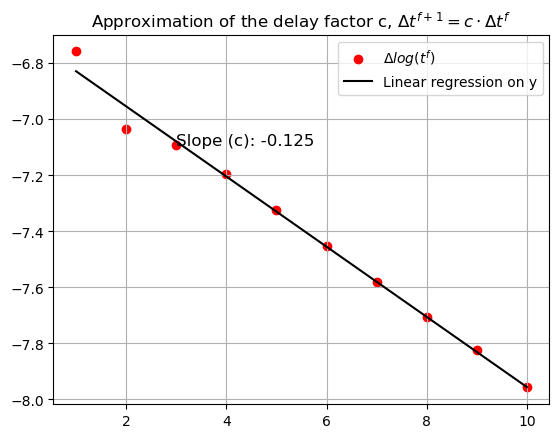

In [49]:
plot_delays(delays5)
plt.savefig(folder+'ex3_1.png')

## Region of attraction
## Question 3

In [50]:
T=5e2*b2.ms
I = np.full(int(T/dt)+1, 0*b2.mA)*1e3*b2.mA
Vi6 =np.full(len(Vs1[-1]), np.median(Vs1[-1][0]))*1e3*b2.mV
i6 = np.random.choice(range(100))
Vi6[i6]=Vi6[i6]+10*b2.mV
Vs6, ST6, epsilonA6,epsilonB6 = synchronous_state(Vi6, dt=dt, T=T, I=I, beta=BETA, eA=epsilonA[-1-int(delta/dt)], eB=epsilonB[-1-int(delta/dt)])

In [51]:
prefix = np.full(int(delta/dt)+1,epsilonA6[0])*b2.Hz
epsilonA6 = np.concatenate((prefix, epsilonA6))[0:-int(delta/dt)-1]*b2.Hz
Isync = epsilonA6*J*MEMBRANE_TIME_SCALE /MEMBRANE_RESISTANCE
Vs7, ST7 = non_interacting(Vi, I=Isync, T=T, dt=dt)

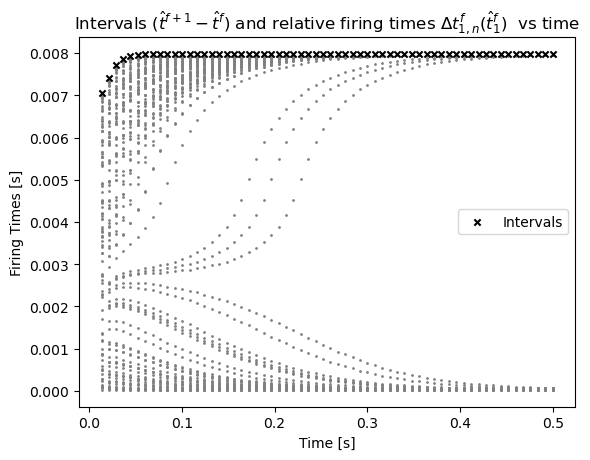

In [52]:
tn1 = np.nonzero(ST6[:,i6-1])[0]
rtimes, intervals, Imins = intervals_spike(ST7, tn1)
plot_intervals(rtimes, intervals, Imins)
plt.savefig(folder+'ex3_2.svg')

## Bonus

In [53]:
dt = 1e-2*b2.ms
T=600*b2.ms
I0=0*b2.mA 
BST = []
Ns = [50,10,5]
delays8 = []
for n in Ns:
  Vs, ST, eA, eB = synchronous_state(Vi[0:n], dt=dt, T=T, I=np.full(int(T/dt), I0)*1e3*b2.mA)
  Vi8=np.full(len(Vs[-1]), np.median(Vs[-1][0]))*1e3*b2.mV
  i = np.random.choice(range(n))
  Vi8[i]=Vi8[i]+10*b2.mV
  _,STbis,_, _ = synchronous_state(Vi8, dt=dt, T=T, I=np.zeros(int(T/dt))*1e3*b2.mA,eA=eA[-1-int(delta/dt)], eB=eB[-1-int(delta/dt)])
  delays8.append(np.abs(np.nonzero(STbis[:, i])[0]-np.nonzero(STbis[:,i-1])[0])[0:10]*dt)
  BST.append(ST)

Figures for N = 50
The period is 0.0079798
The slope is -0.12714633195079555 and the intercept -6.6919626660353515
Figures for N = 10
The period is 0.007980000000000001
The slope is -0.15904640685638533 and the intercept -6.113236670158023
Figures for N = 5
The period is 0.007980000000000001
The slope is -0.11777727394941116 and the intercept -6.111034279598559


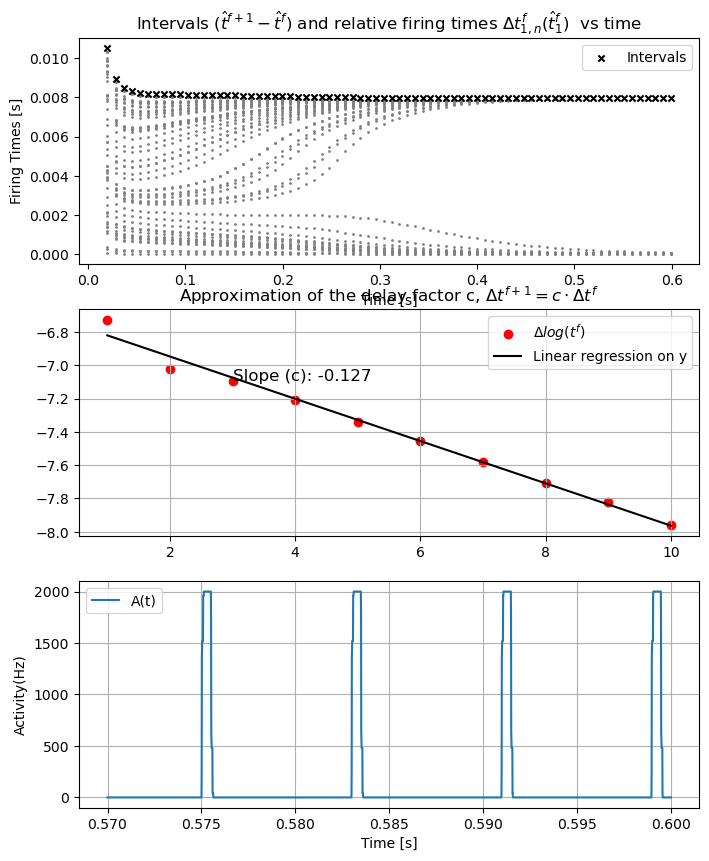

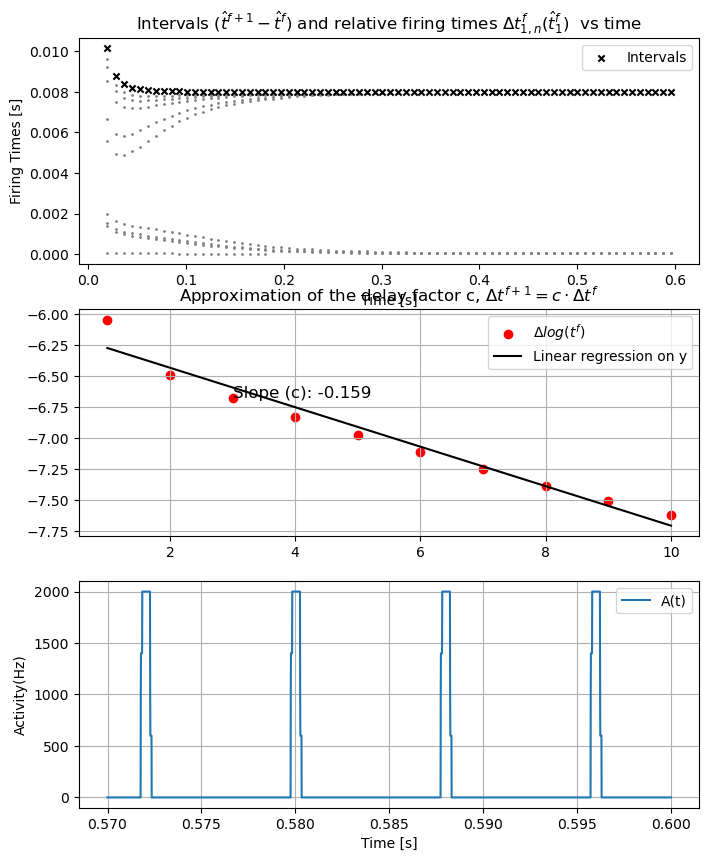

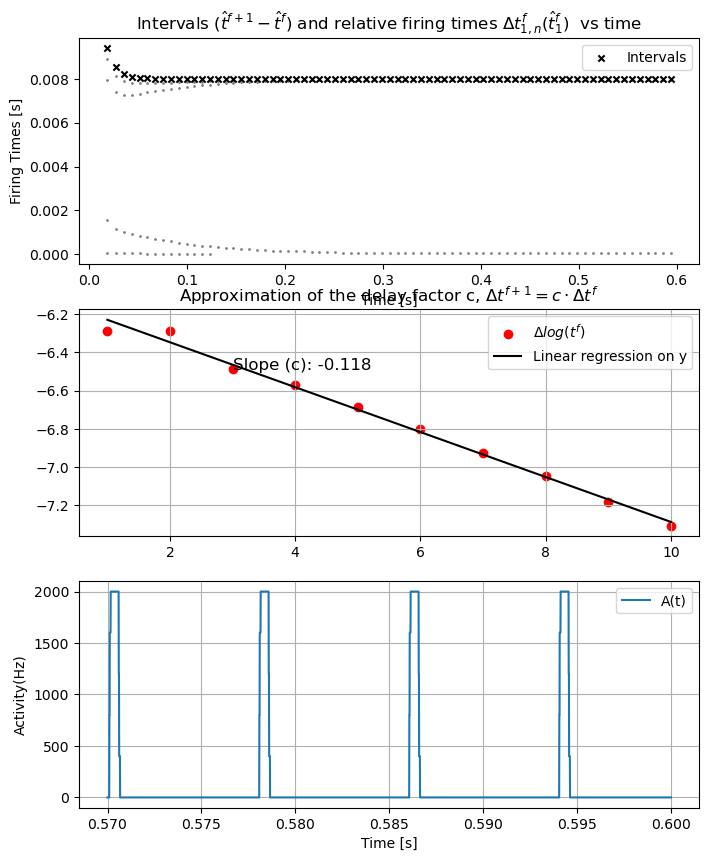

In [59]:
steps = BST[0].shape[0]
t = np.arange(0, steps, 1)
for i, ST in enumerate(BST):  
  fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 10))

  print(f"Figures for N = {Ns[i]}")
  rtimes, intervals, Imins = intervals_spike(ST)
  period = np.mean([np.diff(np.nonzero(s)) for s in ST[-1-i30:-1].T])*dt
  print(f"The period is {period}")
  plot_intervals(rtimes, intervals, Imins, ax1)

  plot_delays(delays8[i], ax2)

  activity_plot(ST[-1-i30:-1],t[-1-i30:-1],ax3, tA=0.5*b2.ms)
  plt.savefig(folder+f'ex4_n{Ns[i]}.png', dpi = 1000)
